In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pykep
import random
from scipy.optimize import newton

Orbit as a function of time

In [57]:
def get_period(a, mu = 398600):
    """`
    return the period in seconds
    a needs to be in km
    """
    return (2*np.pi*a**1.5)/mu**0.5

def kepler(E, M_e, e):
    """Kepler's equation, to be used in a Newton solver."""
    return E - e * np.sin(E) - M_e

def d_kepler_d_E(E, M_e, e):
    """The derivative of Kepler's equation, to be used in a Newton solver.
    
    Note that the argument M_e is unused, but must be present so the function
    arguments are consistent with the kepler function.
    """
    return 1 - e * np.cos(E)

def time_since_perigee(elements):
    a = elements[0]
    e = elements[1]
    E = elements[5]
    E_mean = E - e*np.sin(E)
    T = get_period(a)
    return E_mean * T/(2*np.pi)

def orbit(elements, t):
    """
    Gives the posistion and velocity vectors at time t since the time since perigee as given by the 
    Kepler elements. Propogate forward in time by t from initial pos.
    The elements input needs to be a list of Kepler elements as given by pykep package.
    Only a and e are required for this stage.
    """
    t_perigee = time_since_perigee(elements)
    T = get_period(elements[0])
    t_passed = t_perigee + t
    e = elements[1]
    M_e = 2 * np.pi * t/T
    E = newton(func=kepler, fprime=d_kepler_d_E, x0=np.pi, args=(M_e, e))
    elements[5] = E
    r,v = pykep.par2ic(elements, mu=398600)
    r = np.array(r)
    v = np.array(v)
    return r,v

Unit vectors

In [81]:
def L_meas(elementsO, rel_vector, t):
    """
    Give the unit vector between the known observer orbit and the relative vector
    between the target and observer vector. 
    """
    rO, vO = orbit(elementsO, t)
    rO = np.array(rO)
    rel = rO - rel_vector
    return rel/np.linalg.norm(rel)

def L_between_orbits(elementsO, elementsT, t):
    """
    Give the unit vector between two orbits defined by Kepler elements.
    Only a and e are required for this stage
    This will be used to generate "measured" data.
    """
    print("Target elements in L", elementsT)
    rO, vO = orbit(elementsO, t)
    print("rO", rO)
    rT, vT = orbit(elementsT, t)
    print("rT", rT)
    rO = np.array(rO)
    rT = np.array(rT)
    rel = rT - rO
    print("relative vector", rel)
    unit = rel/np.linalg.norm(rel)
    print("unit vector", unit)
    return unit

Lambert's problem

In [14]:
def constraints(elements, rO_perigee):
    """
    Return true if satisfied.
    """
    a = elements[0]
    e = elements[1]
    R_earth = 6371 # km
    
    if R_earth + 200 <= a and a <= 50000 and 0 <= e and e <= 1 - rO_perigee/50000: # aT_max = 50000 km
        return True
    else:
        return False

In [15]:
def get_target_r(elementsO, elementsT, point, t):
    # initial "measurment" and orbit
    rho_i = point[0]
    rO_i = orbit(elementsO, 0)[0]
    L_t0 = L_between_orbits(elementsO, elementsT, 0)
    rT_i = rho_i*L_t0 + rO_i
    # final "measurment" and orbit
    rho_f = point[1]
    rO_f = orbit(elementsO, t)[0]
    L_tf = L_between_orbits(elementsO, elementsT, t)
    rT_f = rho_f*L_tf + rO_f

    return rT_i, rT_f

def solve_lambert(r1, r2, tof):
    """
    r1 and r2 are vectors (np arrays)
    """
    # convert np array to list for pykep package
    rT_i_list = np.ndarray.tolist(r1)  
    rT_f_list = np.ndarray.tolist(r2)
    # solve Lambert's problem
    l = pykep.lambert_problem(r1 = rT_i_list, r2 = rT_f_list, tof = tof, mu=398600, cw=True)
    # convert results
    vi = l.get_v1()[0]  # get the velocity vector at initial time for one revolution
    elements = pykep.ic2par(rT_i_list,vi, mu=398600)  # get Kepler elements from pos and vel vectors
    return elements

In [16]:
def Lambert_problem(data, elementsO, elementsT, point, rO_perigee, TOF):
    # Set up Lambert's problem
    rT_i, rT_f = get_target_r(elementsO,elementsT, point, TOF)
    # solve Lambert's problem
    elementsT_estimated = list(solve_lambert(r1 = rT_i, r2 = rT_f, tof = TOF))
    if constraints(elementsT_estimated, rO_perigee) is True:
        new_dict = dict(Point = point, Orbit = elementsT_estimated)
        data.append(new_dict)
    if constraints(elementsT_estimated, rO_perigee) is False:
        raise ValueError
    return data

Utility functions

In [17]:
def evaluate_D(elementsO, TOF):
    mu = 398600  # km^3/s^2. Make into a global variable later. Can I make TOF a global variable?
    aO = elementsO[0]
    eO = elementsO[1]
    aT_max = 50000

    # some calculations
    rO_perigee = (1-eO)*aO
    vO_perigee = ((1+eO)/(1-eO) * mu/aO)**0.5
    vT_perigee_max = (2*mu/rO_perigee*(1-rO_perigee/(2*aT_max)))**0.5

    return (vO_perigee + vT_perigee_max)*TOF, rO_perigee

In [26]:
def grid_between_lines(D, N, a=9000):
    distances = []  # a list that will contain the whole population points (rho_i, rho_f)
    A = a*a
    A_s = A - (a-D)*a/2 - (a-2*D)*(a-D)/2
    no_of_nodes = N*A/A_s  # no of nodes in the 9000x9000 (height x width) rectangle

    xs = np.linspace(0, a, int((no_of_nodes)**0.5)) # create values for rho_i
    ys = np.linspace(0, a, int((no_of_nodes)**0.5)) # create values for rho_f
    
    for x in xs:
        for y in ys:
            if y < (x + D) and y > (x - D):
                distances.append([x,y])  # only add points that are between the lines

    #plt.plot(xc, yc, '.r')
    #plt.show()
    
    return distances

In [33]:
def get_elite(data, n=100):
    values = []
    for dict1 in data:
        values.append(dict1["Fit"])
        values.sort(reverse=True)  # descending order

    data_elite = []
    min_value = values[n-1]

    for dict2 in data:
        if dict2["Fit"]>= min_value:
            data_elite.append(dict2)

    return data_elite

def get_best(data):
    max_fit = 0
    i = 0
    for dict1 in data:
        fit = dict1["Fit"]
        if fit > max_fit:
            i_max = i
            max_fit = fit
        i += 1
    return data[i_max]


In [29]:
def show_pop(data):
    xs = []
    ys = []
    for dict1 in data:
        xs.append(dict1["Point"][0])
        ys.append(dict1["Point"][1])
        
    plt.plot(xs, ys, '.k')
    plt.show()

Genetic algorithm building blocks

In [20]:
def mutation(data, elementsO, elementsT, rO_perigee, TOF, no_of_outputs):
    """
    Input how many extra chromoses are wanted.
    """
    stnd_dev = 10  # may change. In the paper they used 10
    for i in range(no_of_outputs):
        passed = False
        while passed is False:
            index = random.randint(0, len(data) - 1)
            rho0, rho1 = data[index]["Point"]
            rho0_new = rho0 + stnd_dev
            rho1_new = rho1 + stnd_dev
            try:
                data = Lambert_problem(data, elementsO, elementsT, [rho0_new, rho1_new], rO_perigee, TOF)
                passed = True
            except ValueError:
                passed = False  # will go back into the loop and select a new random point that passes the constraints
    return data

In [21]:
def one_crossover(point1, point2, D):
    point1[1] = point2[1]
    point2[1] = point1[1]

    if abs(point1[0] - point1[1]) < D and abs(point2[0] - point2[1]) < D:
        if np.random.randint(0,1) == 1:
            return point1
        else:
            return point2
    else:
        return False

def get_random_points(data):
    index1 = random.randint(0, len(data) - 1)
    index2 = random.randint(0, len(data) - 1)
    while index1 == index2:  # can't be the same
        index2 = random.randint(0, len(data) - 1)
    point1 = data[index1]["Point"]
    point2 = data[index2]["Point"]
    return point1, point2

def crossover(data, elementsO, elementsT, rO_perigee, TOF, no_of_outputs, D):
    for i in range(no_of_outputs):
        passed = False
        while passed is False:
            point1, point2 = get_random_points(data)
            extra_point = one_crossover(point1, point2, D)
            while extra_point == False:
                point1, point2 = get_random_points(data)
                extra_point = one_crossover(point1, point2, D)  # the inequality must be satisfied
            try:
                data = Lambert_problem(data, elementsO, elementsT, extra_point, rO_perigee, TOF)  # solve for orbits
                passed = True
            except ValueError:
                passed = False  # will go back into the loop and select a new random point that passes the constraints
    return data


In [83]:
def fitness(elementsO, elementsT, estimated_orbit, no_of_measurments = 60):
    """
    For now it compares against the ideal.
    """
    fit = 1
    for t in range(no_of_measurments):
        print("L ideal")
        L_ideal = L_between_orbits(elementsO, elementsT, t)
        print("L ast")
        L_ast = L_between_orbits(elementsO, estimated_orbit, t)
        print("dot product", np.dot(L_ideal, L_ast))
        fit = fit * np.dot(L_ideal, L_ast)
        print("---")
    return fit

def objective_func(elementsO, elementsT, data):
    index = 0
    fit_values = []
    for og_dict in data:
        fit_value = fitness(elementsO, elementsT, og_dict["Orbit"])
        og_dict["Fit"] = fit_value   # fitness value in the data

    return data


In [132]:
elements_deb = [7100,0.0043,np.radians(98.289),np.radians(49.866),np.radians(356.768),0]
elements_sat = [7133.8,0.0043,np.radians(98.289),np.radians(49.866),np.radians(356.768),0]

fitness(elements_sat, elements_deb, elements_deb)

0.19035362528039013

In [23]:
def initialise_pop(elementsO, elementsT, TOF=60, N=1000):
    """
    Initialises the population of specific size
    Returns the population along with the orbits.
    """
    D, rO_perigee = evaluate_D(elementsO, TOF)
    # get an evenly spaced grid between two lines Rho in the range [0,9000]
    original_population = grid_between_lines(D, N)  # initial population
    data = []
    
    for point in original_population:
        try:
            data = Lambert_problem(data, elementsO, elementsT, point, rO_perigee, TOF)
        except ValueError:
            continue
    
    n = len(data)
    
    if n > N:
        # remove the number of extra points randomly
        no_of_extra_points = n - N
        for i in range(no_of_extra_points):
            index = random.randint(0, len(data)-1)
            data.pop(index)

    if n < N:
        # gain extra points via mutation
        no_of_extra_points = N - n
        data = mutation(data, elementsO, elementsT, rO_perigee, TOF, no_of_extra_points)  # for new points I have to solve for the orbit again
        
        
    return data

Stop conditions

In [24]:
def mean(data):
    n = len(data)
    sum_i = 0
    sum_f = 0
    for dict1 in data:
        sum_i += dict1["Point"][0]
        sum_f += dict1["Point"][1]
    return sum_i/n, sum_f/n    

def covariance_matrix(data):
    """
    Returns the standard deviations of the population in terms of two variables.
    Our points consist of initial and final distance.
    """
    c11 = 0
    c12 = 0
    c22 = 0
    mean_i, mean_f = mean(data)
    n = len(data)
    for dict1 in data:
        c11 += (dict1["Point"][0]-mean_i)**2
        c12 += (dict1["Point"][0]-mean_i)*(dict1["Point"][1]-mean_f)
        c22 += (dict1["Point"][1]-mean_f)**2
    return (c11/n)**0.5, (c22/n)**0.5, (c12/n)**0.5

def last_similarity(List, error = 0):
    """
    The input list should be a list (2x2) in a list of length phi.
    Return true if all the elements in the list are similar (same) comapred to the last element.
    """
    value1, value2 = List[-1]
    for point in List:
        last_value1, last_value2 = point
        difference1 = abs(last_value1 - value1)
        difference2 = abs(last_value2 - value2)
        if difference1 <= error and difference2 <= error:
            continue
        else:
            return False   # is not similar
    return True  # is similar
    
def stop_criteria(data, last_means, last_best_values, no_of_gens,lim_O = 5, lim_F = 5, max_gen=30,error = 0):
    """
    Returns True if met.
    """
    # for means
    means_sim = last_similarity(last_means)
    # for best values
    best_sim = last_similarity(last_best_values)
    # standard values
    sigma_OO, sigma_FF, sigma_OF = covariance_matrix(data)
    print("standard dev", sigma_OO, sigma_FF, sigma_OF)
    
    if means_sim == True or best_sim == True:
        print("similarity")
        return True
    if no_of_gens >= max_gen:
        print("max gens")
        return True, None, None
    if sigma_OO <= lim_O and sigma_FF <= lim_F:
        print("stnd dev")
        return True
    else:
        return False  # need these values for the next iteration

Initialisation

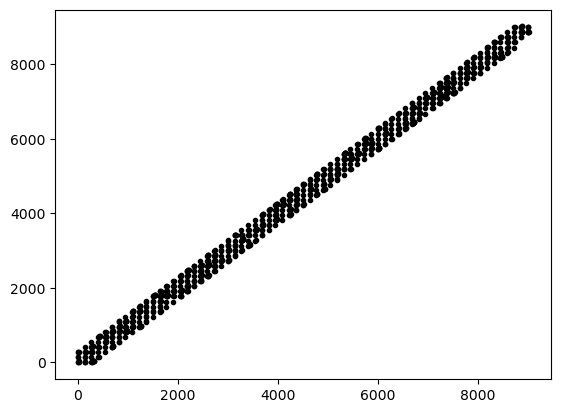

In [30]:
elements_deb = [7100,0.0043,np.radians(98.289),np.radians(49.866),np.radians(356.768),0]
elements_sat = [7133.8,0.0043,np.radians(98.289),np.radians(49.866),np.radians(356.768),0]

# initialise
data = initialise_pop(elements_sat, elements_deb, N=1000)
show_pop(data)

In [31]:
data = objective_func(elements_sat, elements_deb, data)

In [34]:
best_point = get_best(data)["Point"]
no_of_gens = 0
phi = 3
print("best point", best_point)
last_means = [(0,0) for x in range(phi)]
last_means.pop(0)
last_means.append(mean(data))

last_best_values = [(0,0) for x in range(phi)]
last_best_values.pop(0)
last_best_values.append(best_point)

D, rO_perigee = evaluate_D(elements_sat, 60)  # maybe there is a better way to define this

best point [4909.09090909091, 4909.09090909091]


Body

In [35]:
while stop_criteria(data, last_means, last_best_values, no_of_gens) is False:
    
    data_elite = get_elite(data)
    print("elite", data_elite)
    # create new population and corresponding orbits
    data_created = initialise_pop(elements_sat, elements_deb, N=50)  # create 5% of desired population size

    #mutate
    data_mutation = mutation(data_elite, elements_sat, elements_deb, rO_perigee, 60, 800)  # 800 corresponds to 80% of desired population 

    # crossover
    data_crossover = crossover(data_mutation, elements_sat, elements_deb, rO_perigee, 60, 50, D)  # crossover 5% of desired population size

    data = data_crossover + data_created
    print("final", len(data))

    # get new fit_values
    data = objective_func(elements_sat, elements_deb, data)
    
    # update last_means, last_best_values, no_of_gens
    last_means.pop(0)
    last_means.append(mean(data))
    print("last means", last_means)
    best_point = get_best(data)["Point"]
    print("the best", best_point)
    last_best_values.pop(0)
    last_best_values.append(best_point)
    print("last bests", last_best_values)
    no_of_gens += 1
else:
    print("donzo")

standard dev 2578.7325367293884 2575.3833123261998 2573.5886077172295
elite [{'Point': [3409.0909090909095, 3409.0909090909095], 'Orbit': [9230.300035691982, 0.14151826618191948, 1.7154666684925355, 0.8703258847995, 2.917379821236107, 0.048925730060262476], 'Fit': 0.9255237985279885}, {'Point': [3545.454545454546, 3545.454545454546], 'Orbit': [9264.25559385444, 0.15205938906847297, 1.7154666684925308, 0.8703258847995005, 2.9251743453765573, 0.04926153455368163], 'Fit': 0.9361155478453296}, {'Point': [3681.818181818182, 3681.818181818182], 'Orbit': [9295.374064842592, 0.16287947725072902, 1.7154666684925164, 0.870325884799501, 2.932360084742788, 0.04964753082379958], 'Fit': 0.9449575872815913}, {'Point': [3818.1818181818185, 3818.1818181818185], 'Orbit': [9323.795334912733, 0.173967938137592, 1.715466668492506, 0.8703258847995016, 2.9390063693001363, 0.05008370222986436], 'Fit': 0.9522869331088069}, {'Point': [3954.545454545455, 3954.545454545455], 'Orbit': [9349.658851947506, 0.1853141

Debug

In [64]:
print(best_point)

D, rO_perigee = evaluate_D(elements_sat, 60)
# Set up Lambert's problem
rT_i, rT_f = get_target_r(elements_sat,elements_deb, [4686.363636363637, 4686.363636363637], 60)
# solve Lambert's problem
elementsT_estimated = list(solve_lambert(r1 = rT_i, r2 = rT_f, tof = 60))
print(elementsT_estimated)
fit = fitness(elements_sat, elements_deb, elementsT_estimated, no_of_measurments = 60)
print(fit)

[4909.09090909091, 5075.454545454546]
rO [4527.09153408 5459.19231875 -396.28449932]
rT [4505.64213911 5433.326623   -394.40690027]
rO [4583.9240548  5425.90686397   49.22689317]
rT [4562.54426048 5399.8840056    52.16508557]
[9450.49625553981, 0.2501664703342994, 1.7154666684924387, 0.8703258847995052, 2.9719140826855535, -2.995440490696146]
rO [4527.09153408 5459.19231875 -396.28449932]
rT [4505.64213911 5433.326623   -394.40690027]
ideal [ 0.63733804  0.76856209 -0.05579017]
rO [4527.09153408 5459.19231875 -396.28449932]
rT [-4370.1789334  -5451.14690981  1184.13110353]
ast [ 0.62804232  0.77014122 -0.11155869]
0.9984004835357199
rO [4528.18796022 5458.81636895 -388.86736009]
rT [4506.74115391 5432.94975764 -386.97212556]
ideal [ 0.63726032  0.76858832 -0.05631411]
rO [4528.18796022 5458.81636895 -388.86736009]
rT [-4372.00026209 -5451.4584279   1175.95144521]
ast [ 0.62824598  0.77013386 -0.11045734]
0.9984924316625818
rO [4529.27935004 5458.43434777 -381.44978835]
rT [4507.8350843

In [84]:
fit = fitness(elements_sat, elements_deb, [9450.49625553981, 0.2501664703342994, 1.7154666684924387, 0.8703258847995052, 2.9719140826855535, -2.995440490696146], no_of_measurments = 60)
fit

L ideal
Target elements in L [7100, 0.0043, 1.7154666684927067, 0.8703258847994924, 6.226776265755129, 0.06253215656084941]
rO [4527.09153408 5459.19231875 -396.28449932]
rT [4505.64213911 5433.326623   -394.40690027]
relative vector [-21.44939497 -25.86569575   1.87759905]
unit vector [-0.63733804 -0.76856209  0.05579017]
L ast
Target elements in L [9450.49625553981, 0.2501664703342994, 1.7154666684924387, 0.8703258847995052, 2.9719140826855535, -2.995440490696146]
rO [4527.09153408 5459.19231875 -396.28449932]
rT [-4370.1789334  -5451.14690981  1184.13110353]
relative vector [ -8897.27046749 -10910.33922856   1580.41560285]
unit vector [-0.62804232 -0.77014122  0.11155869]
dot product 0.9984004835357199
---
L ideal
Target elements in L [7100, 0.0043, 1.7154666684927067, 0.8703258847994924, 6.226776265755129, 0.0]
rO [4528.18796022 5458.81636895 -388.86736009]
rT [4506.74115391 5432.94975764 -386.97212556]
relative vector [-21.44680631 -25.86661131   1.89523452]
unit vector [-0.637260

0.9740638109511262

Python reminder

In [103]:
L = [1,3,6,2,4]
Ln = L.copy()
Ln.sort()
L

[1, 3, 6, 2, 4]

In [ ]:
l=[0 for x in range(5)]
l

[0, 0, 0, 0, 0]

In [10]:
l = [1,2,3,4,54,5,5,5,5,5,5]
l.sort()
l

[1, 2, 3, 4, 5, 5, 5, 5, 5, 5, 54]

In [5]:
l = [{"brand": "Ford",
  "model": "Mustang",
  "year": 1964
}, {
  "brand": "Volvo",
  "model": "SUV",
  "year": 2018
},
{"brand": "Audi",
  "model": "A7",
  "year": 2013},
  ]

for dict1 in l:
    if dict1["year"] >= 2000:
        dict1["new"] = True

# order l based on year
years = []
for dict1 in l:
    years.append(dict1["year"])
    years.sort()

years

[1964, 2013, 2018]

In [99]:
e1 = [9450.49625553981, 0.2501664703342994, 1.7154666684924387, 0.8703258847995052, 2.9719140826855535, -2.995440490696146]
r, v = pykep.par2ic(e1, mu=398600)
rf,vf = pykep.propagate_lagrangian(r0 = r, v0 = v, tof = 50,mu = 398600)
e2 = pykep.ic2par(rf,vf,mu = 398600)
e2

(9450.496255539807,
 0.25016647033429984,
 1.7154666684924387,
 0.8703258847995052,
 2.971914082685554,
 -2.9678853860378602)

In [101]:
np.radians(180)

3.141592653589793